In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

C:\Users\vy\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('Sale.csv')
df

,CREATED_AT_TIMESTAMP,USD_CALCULATED_NET_REVENUE
0,2023-07-12T12:28:51Z,4.24
1,2023-07-12T12:39:36Z,487.11
2,2023-07-12T12:39:36Z,119.07
3,2023-07-12T12:39:36Z,86.59
4,2023-07-12T12:41:15Z,254.39
...,...,...
116588,2023-06-16T13:00:38Z,741.99
116589,2023-06-16T13:14:36Z,85.59
116590,2023-06-16T13:30:28Z,0.00
116591,2023-06-16T13:58:28Z,0.00


In [3]:
df.dtypes

CREATED_AT_TIMESTAMP           object
USD_CALCULATED_NET_REVENUE    float64
dtype: object

In [4]:
df = df.set_index('CREATED_AT_TIMESTAMP')
df.index = pd.to_datetime(df.index)
df

,USD_CALCULATED_NET_REVENUE
CREATED_AT_TIMESTAMP,
2023-07-12 12:28:51+00:00,4.24
2023-07-12 12:39:36+00:00,487.11
2023-07-12 12:39:36+00:00,119.07
2023-07-12 12:39:36+00:00,86.59
2023-07-12 12:41:15+00:00,254.39
...,...
2023-06-16 13:00:38+00:00,741.99
2023-06-16 13:14:36+00:00,85.59
2023-06-16 13:30:28+00:00,0.00


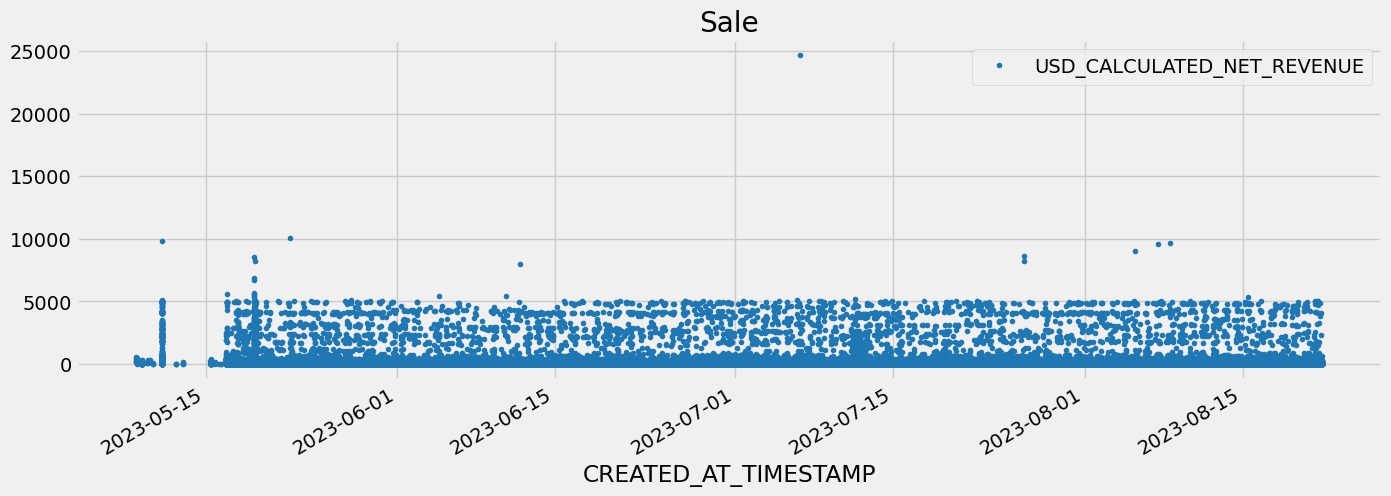

In [5]:
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0],
        title='Sale')
plt.show()

In [6]:
df = df.rename(columns = {'USD_CALCULATED_NET_REVENUE':'Revenue_USD'})
df

,Revenue_USD
CREATED_AT_TIMESTAMP,
2023-07-12 12:28:51+00:00,4.24
2023-07-12 12:39:36+00:00,487.11
2023-07-12 12:39:36+00:00,119.07
2023-07-12 12:39:36+00:00,86.59
2023-07-12 12:41:15+00:00,254.39
...,...
2023-06-16 13:00:38+00:00,741.99
2023-06-16 13:14:36+00:00,85.59
2023-06-16 13:30:28+00:00,0.00


# outlier removal

<AxesSubplot:ylabel='Frequency'>

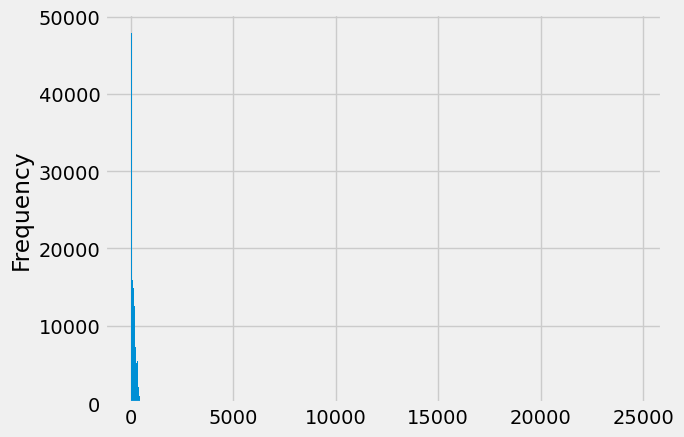

In [7]:
df['Revenue_USD'].plot(kind='hist', bins=500)

<AxesSubplot:xlabel='CREATED_AT_TIMESTAMP'>

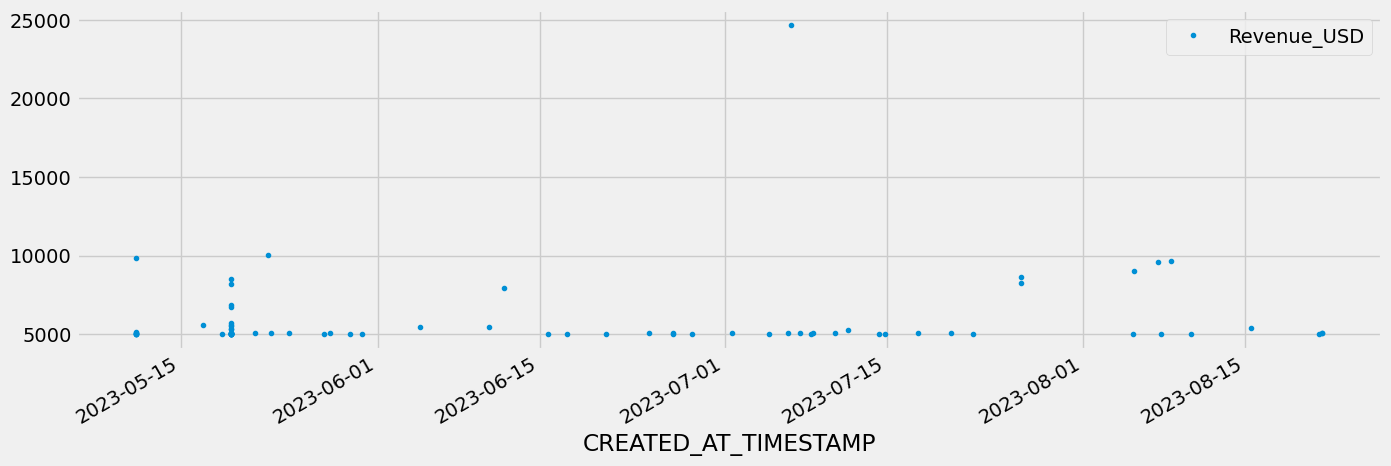

In [8]:
df.query('Revenue_USD > 5000').plot(figsize=(15,5), style='.')

In [9]:
df = df.query('Revenue_USD < 5000').copy()
#remove all value higher than 5000 USD

<AxesSubplot:xlabel='CREATED_AT_TIMESTAMP'>

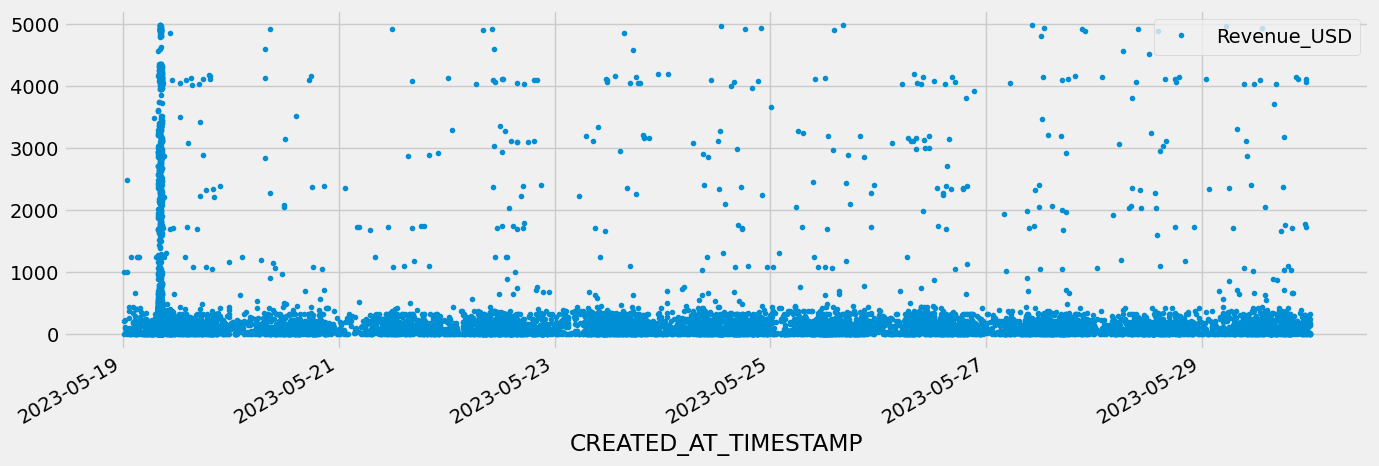

In [10]:
df.loc[(df.index > '2023-05-19') & (df.index < '2023-05-30')].plot(figsize=(15,5), style='.')

Conclusion about outliers:
1. Should exclude values > $5000
2. Should exclude time < 20-May 

finally: choose train set from 21-May
test set: we will try 2 option: predict 1 week and also check feature importances

# Predict 1 week

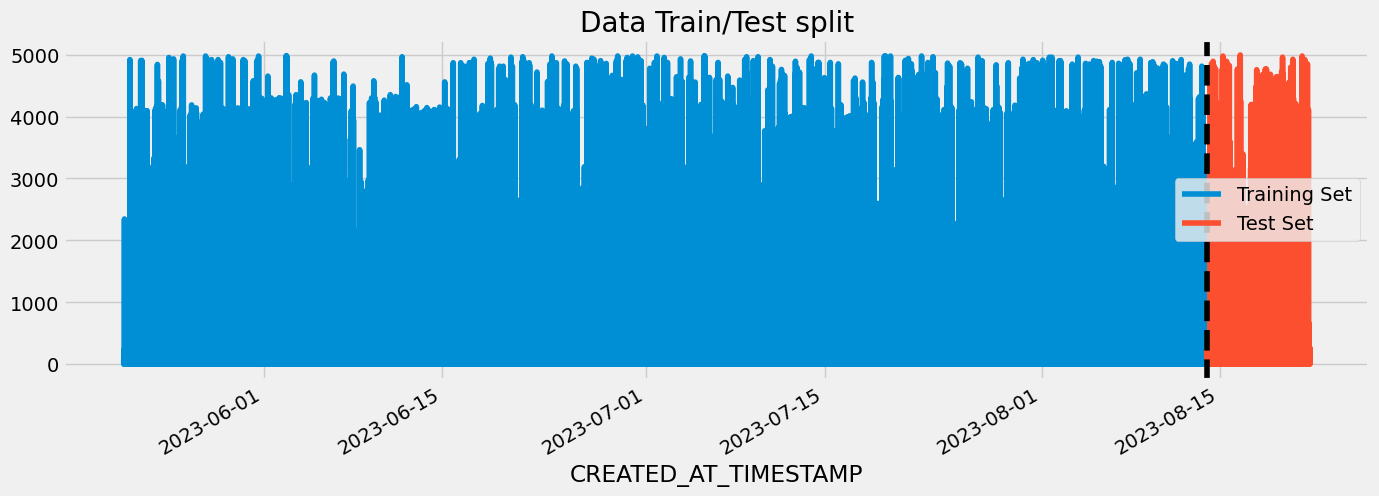

In [11]:
# Train/Test Split
train = df.loc[(df.index > '2023-05-21') & (df.index < '2023-08-14')]
test = df.loc[df.index >= '2023-08-14']
fig, ax = plt.subplots (figsize=(15,5))
train.plot(ax=ax, label = 'Training set', title = 'Data Train/Test split')
test.plot(ax=ax, label = 'Test set')
ax.axvline('2023-08-14', color='black', ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

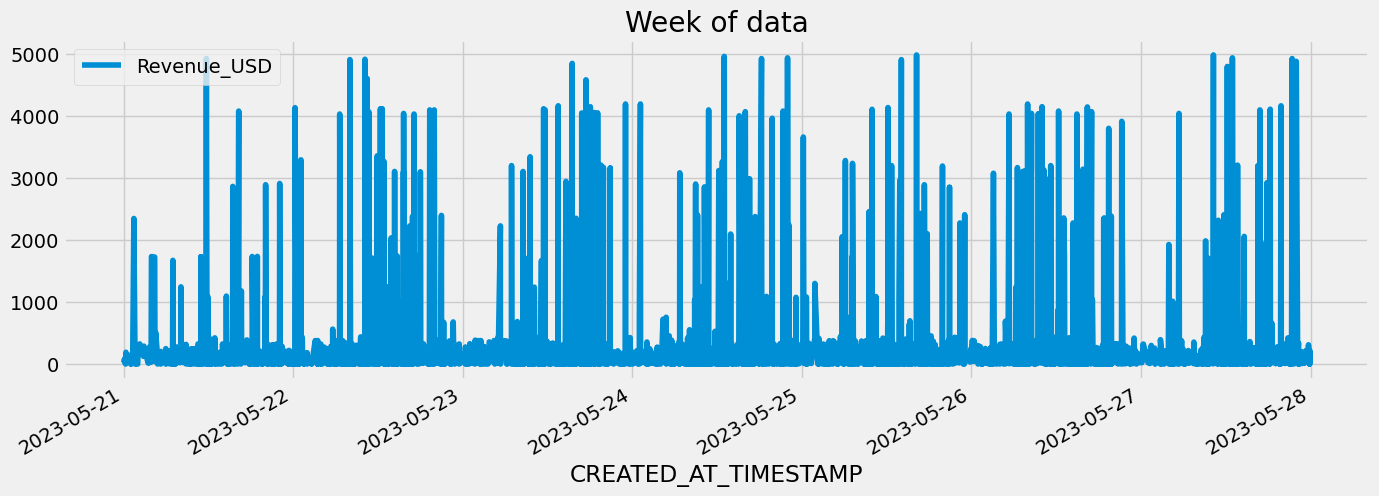

In [12]:
df.loc[(df.index > '2023-05-21') & (df.index < '2023-05-28')].plot(figsize=(15,5), title = 'Week of data')
plt.show()

# Create Features

In [13]:
def create_features(df):
    #Create time series feature based on time series index
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['month']=df.index.month
    return df

In [14]:
df = create_features(df)

# Visualize feature / target relationship

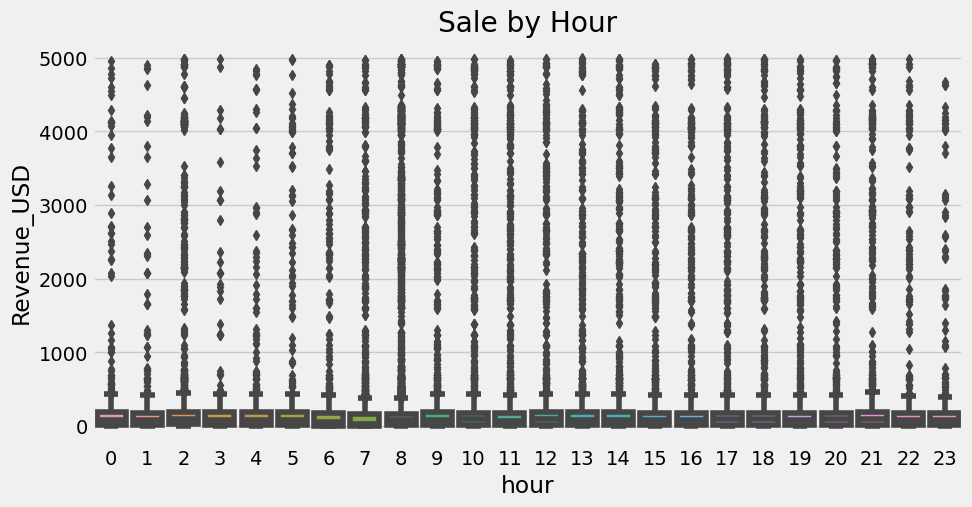

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df, x='hour', y='Revenue_USD')
ax.set_title('Sale by Hour')
plt.show()

# initial assessment:
from value distribution, we can see that amount of sales with low revenue is main part and it could impact prediction of model. So we need new feature add in like brand or product_id. Will do it later. 
Let's continue with our current dataset

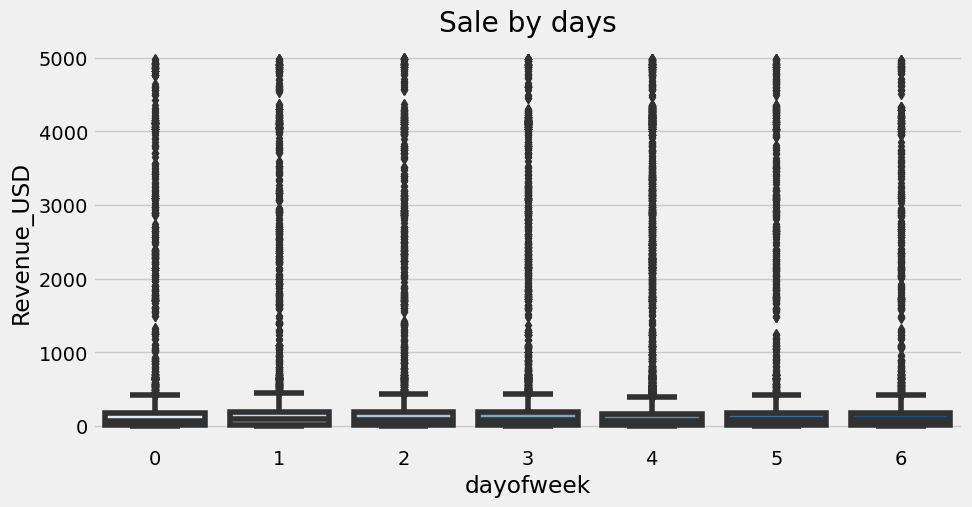

In [16]:
#draw by days
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df, x='dayofweek', y='Revenue_USD', palette='Blues')
ax.set_title('Sale by days')
plt.show()

In [17]:
# create model
train = create_features(train)
test = create_features(test)

C:\Users\vy\AppData\Local\Temp\ipykernel_14456\985091205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour']=df.index.hour
C:\Users\vy\AppData\Local\Temp\ipykernel_14456\985091205.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek']=df.index.dayofweek
C:\Users\vy\AppData\Local\Temp\ipykernel_14456\985091205.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [18]:
df.columns

Index(['Revenue_USD', 'hour', 'dayofweek', 'month'], dtype='object')

In [19]:
FEATURES = ['hour','dayofweek','month']
TARGET = 'Revenue_USD'
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [20]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(x_train, y_train,
       eval_set=[(x_train, y_train),(x_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:582.08878	validation_1-rmse:553.34509
[100]	validation_0-rmse:551.37053	validation_1-rmse:524.41093
[200]	validation_0-rmse:546.89220	validation_1-rmse:522.41582
[250]	validation_0-rmse:546.35998	validation_1-rmse:522.55105


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

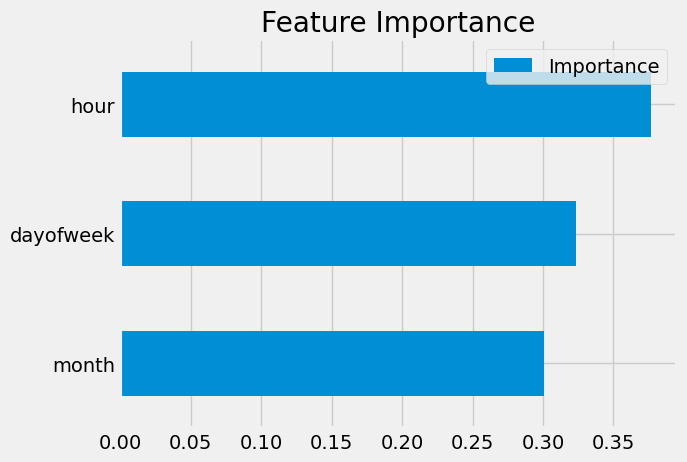

In [21]:
# Feature importance
fi = pd.DataFrame(reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['Importance'])
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [22]:
# Forecast on set
test['Prediction'] = reg.predict(x_test)
df = df.merge(test[['Prediction']], how='left', left_index=True, right_index=True)
df

C:\Users\vy\AppData\Local\Temp\ipykernel_14456\1914307374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = reg.predict(x_test)


,Revenue_USD,hour,dayofweek,month,Prediction
CREATED_AT_TIMESTAMP,,,,,
2023-05-08 20:02:56+00:00,272.18,20,0,5,NaN
2023-05-08 20:02:56+00:00,544.35,20,0,5,NaN
2023-05-08 20:48:43+00:00,152.41,20,0,5,NaN
2023-05-08 20:48:43+00:00,449.99,20,0,5,NaN
2023-05-08 20:48:43+00:00,228.63,20,0,5,NaN
...,...,...,...,...,...
2023-08-22 01:08:15+00:00,216.90,1,1,8,133.440277
2023-08-22 01:10:11+00:00,0.00,1,1,8,133.440277
2023-08-22 01:11:44+00:00,97.41,1,1,8,133.440277


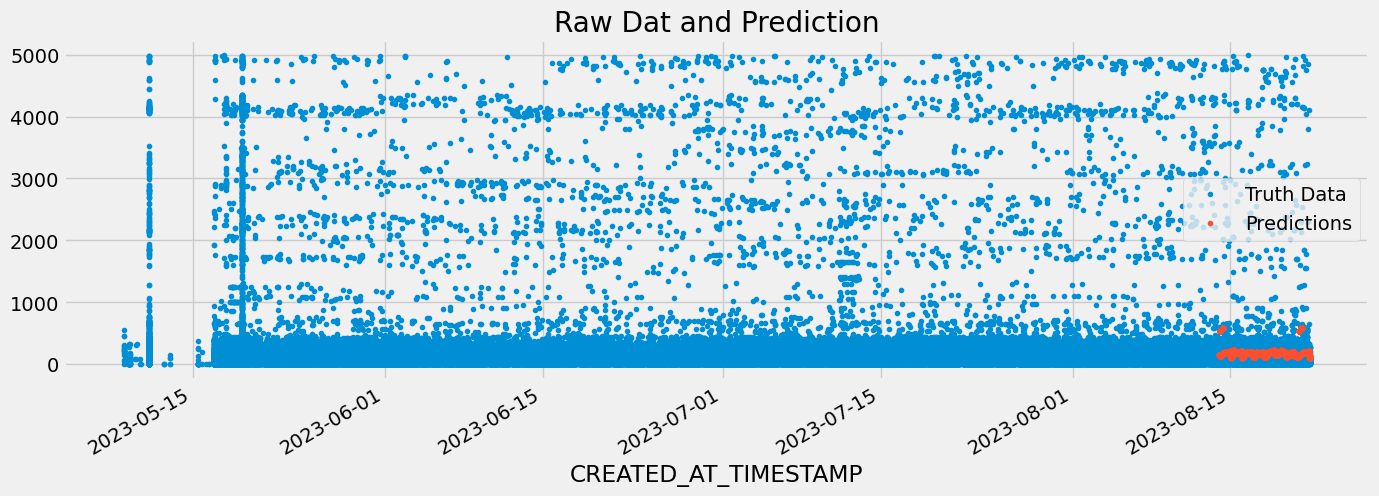

In [23]:
ax=df[['Revenue_USD']].plot(figsize=(15,5),style='.')
df['Prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

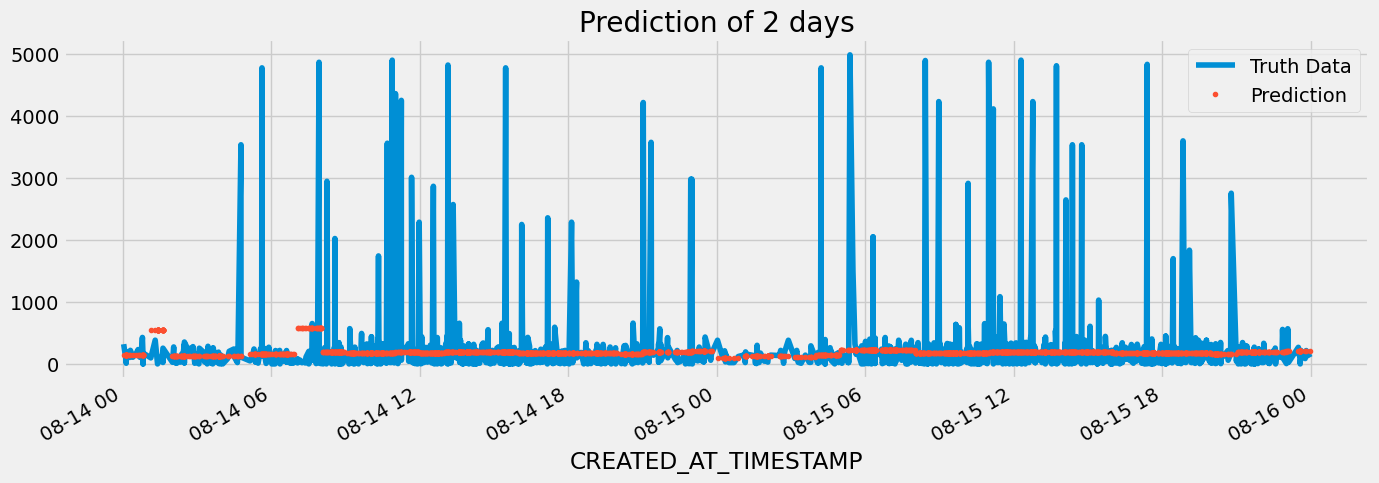

In [24]:
ax = df.loc[(df.index > '2023-08-14') & (df.index < '2023-08-16')]['Revenue_USD'].plot(figsize=(15, 5), title='Prediction of 2 days')
df.loc[(df.index > '2023-08-14') & (df.index < '2023-08-16')]['Prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# test prediction with dataset with new information of product name, currency, price

In [49]:
df_new = pd.read_csv('Sale1.csv')
df_new

,TIME,CURRENCY,USD_PRICE,USD_NET_REVENUE
0,2023-07-25T14:26:08Z,USD,19.99,21.49
1,2023-07-25T14:26:08Z,USD,19.99,21.49
2,2023-07-25T14:26:08Z,USD,11.99,12.89
3,2023-07-25T17:47:17Z,USD,64.99,70.35
4,2023-07-26T02:06:09Z,EUR,110.49,110.49
...,...,...,...,...
116588,2023-06-04T05:44:48Z,USD,109.99,117.96
116589,2023-06-04T05:55:55Z,EUR,21.34,21.34
116590,2023-06-04T05:55:55Z,EUR,24.56,24.56
116591,2023-06-04T06:06:01Z,USD,289.99,313.91


In [50]:
df_new.columns

Index(['TIME', 'CURRENCY', 'USD_PRICE', 'USD_NET_REVENUE'], dtype='object')

In [51]:
df_new.duplicated().sum()

6546

In [52]:
df_new['TIME']=pd.to_datetime(df_new['TIME'])
df_new

,TIME,CURRENCY,USD_PRICE,USD_NET_REVENUE
0,2023-07-25 14:26:08+00:00,USD,19.99,21.49
1,2023-07-25 14:26:08+00:00,USD,19.99,21.49
2,2023-07-25 14:26:08+00:00,USD,11.99,12.89
3,2023-07-25 17:47:17+00:00,USD,64.99,70.35
4,2023-07-26 02:06:09+00:00,EUR,110.49,110.49
...,...,...,...,...
116588,2023-06-04 05:44:48+00:00,USD,109.99,117.96
116589,2023-06-04 05:55:55+00:00,EUR,21.34,21.34
116590,2023-06-04 05:55:55+00:00,EUR,24.56,24.56
116591,2023-06-04 06:06:01+00:00,USD,289.99,313.91


In [53]:
# Create dataset onehot
df_new = pd.get_dummies(df_new,drop_first=True)


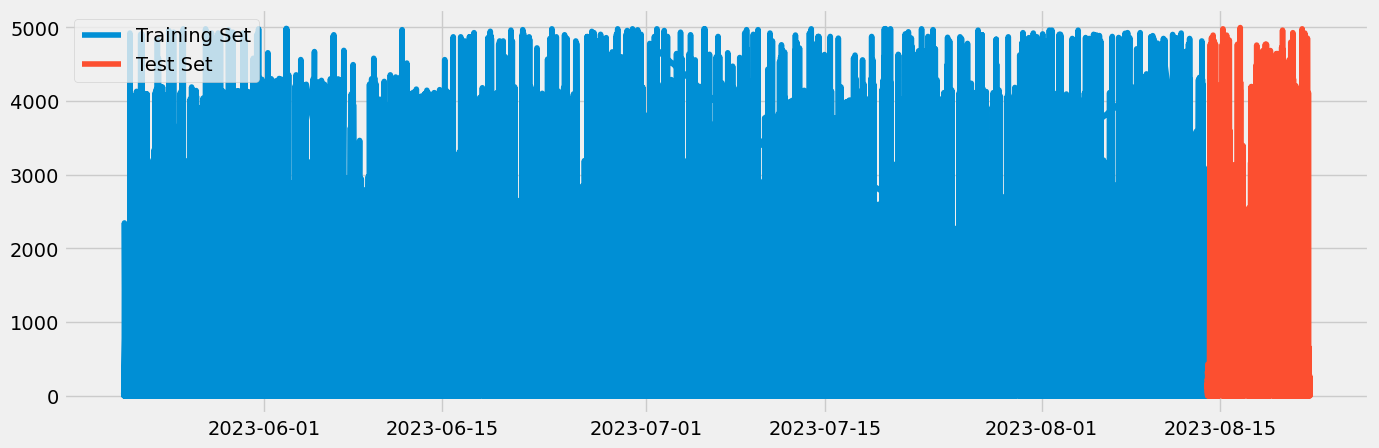

In [55]:
#remove outliers and create train/test set
df_new = df_new.query('USD_NET_REVENUE < 5000').copy()

# Train/Test Split
train = df_new.loc[(df_new['TIME'] > '2023-05-21') & (df_new['TIME'] < '2023-08-14')]
test = df_new.loc[(df_new['TIME'] > '2023-08-14')]
fig, ax = plt.subplots (figsize=(15,5))
plt.plot(train['TIME'],train['USD_NET_REVENUE'], label = 'Training set')
plt.plot(test['TIME'],test['USD_NET_REVENUE'], label = 'Test set')
ax.legend(['Training Set','Test Set'])
plt.show()

In [56]:
def create_time_features(df):
    #Create time series feature based on time series index
    df['hour']=df['TIME'].dt.hour
    df['dayofweek']=df['TIME'].dt.dayofweek
    df['month']=df['TIME'].dt.month
    return df

In [57]:
df_new = create_time_features(df_new)
train = create_time_features(train)
test = create_time_features(test)

C:\Users\vy\AppData\Local\Temp\ipykernel_14456\2441632502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour']=df['TIME'].dt.hour
C:\Users\vy\AppData\Local\Temp\ipykernel_14456\2441632502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek']=df['TIME'].dt.dayofweek
C:\Users\vy\AppData\Local\Temp\ipykernel_14456\2441632502.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [58]:
df_new.columns

Index(['TIME', 'USD_PRICE', 'USD_NET_REVENUE', 'CURRENCY_EUR', 'CURRENCY_GBP',
       'CURRENCY_PLN', 'CURRENCY_RON', 'CURRENCY_SEK', 'CURRENCY_TWD',
       'CURRENCY_USD', 'hour', 'dayofweek', 'month'],
      dtype='object')

In [59]:
x_train = train.drop(['USD_NET_REVENUE','TIME'], axis = 1)
y_train = train['USD_NET_REVENUE']

x_test = test.drop(['USD_NET_REVENUE','TIME'], axis = 1)
y_test = test['USD_NET_REVENUE']


In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train[['USD_PRICE']])
x_train['USD_PRICE'] = scaler.transform (x_train[['USD_PRICE']])
x_test['USD_PRICE'] = scaler.transform (x_test[['USD_PRICE']])


In [61]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(x_train, y_train,
       eval_set=[(x_train, y_train),(x_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:577.91092	validation_1-rmse:549.54425
[100]	validation_0-rmse:300.05323	validation_1-rmse:286.41725
[200]	validation_0-rmse:233.91607	validation_1-rmse:215.65521
[300]	validation_0-rmse:218.93840	validation_1-rmse:201.94459
[400]	validation_0-rmse:211.42857	validation_1-rmse:199.48533
[500]	validation_0-rmse:206.50520	validation_1-rmse:197.29494
[563]	validation_0-rmse:202.77108	validation_1-rmse:198.44988


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

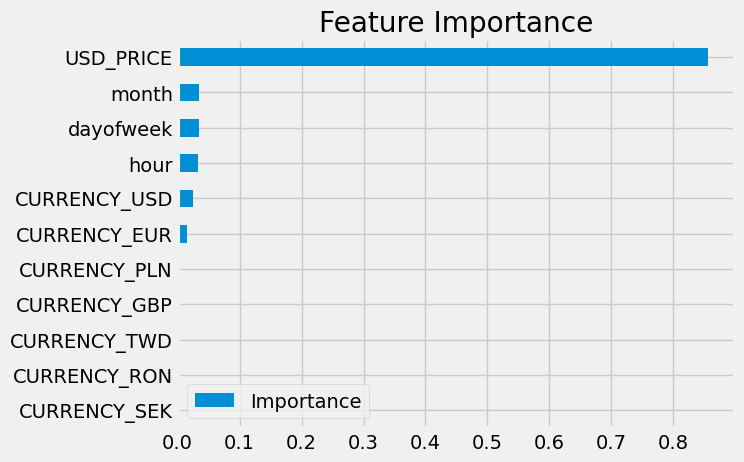

In [62]:
# Feature importance
fi = pd.DataFrame(reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['Importance'])
fi.sort_values('Importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [63]:
# Forecast on set
test['Prediction'] = reg.predict(x_test)
df_new = df_new.merge(test[['Prediction']], how='left', left_index=True, right_index=True)
df_new

C:\Users\vy\AppData\Local\Temp\ipykernel_14456\2738803900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = reg.predict(x_test)


,TIME,USD_PRICE,USD_NET_REVENUE,CURRENCY_EUR,CURRENCY_GBP,CURRENCY_PLN,CURRENCY_RON,CURRENCY_SEK,CURRENCY_TWD,CURRENCY_USD,hour,dayofweek,month,Prediction
0,2023-07-25 14:26:08+00:00,19.99,21.49,0,0,0,0,0,0,1,14,1,7,NaN
1,2023-07-25 14:26:08+00:00,19.99,21.49,0,0,0,0,0,0,1,14,1,7,NaN
2,2023-07-25 14:26:08+00:00,11.99,12.89,0,0,0,0,0,0,1,14,1,7,NaN
3,2023-07-25 17:47:17+00:00,64.99,70.35,0,0,0,0,0,0,1,17,1,7,NaN
4,2023-07-26 02:06:09+00:00,110.49,110.49,1,0,0,0,0,0,0,2,2,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116588,2023-06-04 05:44:48+00:00,109.99,117.96,0,0,0,0,0,0,1,5,6,6,NaN
116589,2023-06-04 05:55:55+00:00,21.34,21.34,1,0,0,0,0,0,0,5,6,6,NaN
116590,2023-06-04 05:55:55+00:00,24.56,24.56,1,0,0,0,0,0,0,5,6,6,NaN
116591,2023-06-04 06:06:01+00:00,289.99,313.91,0,0,0,0,0,0,1,6,6,6,NaN


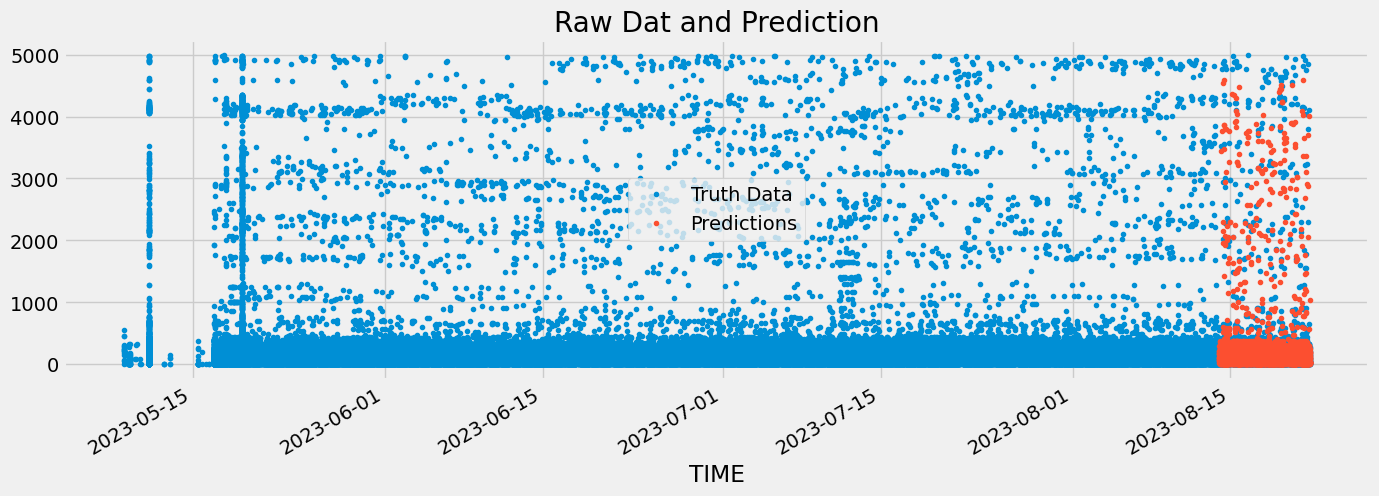

In [65]:
df_new=df_new.set_index('TIME')

ax=df_new[['USD_NET_REVENUE']].plot(figsize=(15,5),style='.')
df_new['Prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# Conclusion
Product price is the most important feature, which we didn't know from the first data set.
With the right dataset, model accuracy can be improved significantly